# **Mini Project #5 – Kernel-Based Support Vector Machine (Nonlinear Data)**  
### *James Levi*

1. Implement a support vector machine to separate and classify the two linearly separable sets
given in the data file SVM_data.mat available on Canvas.
Find and show the classifying line. How many support vectors do you have? Mark your support
vectors.

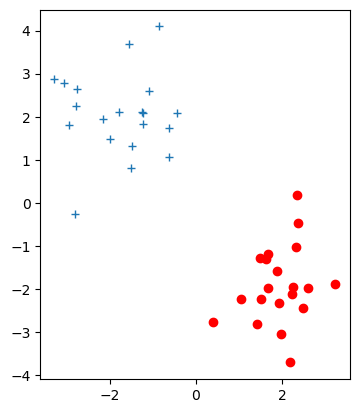

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Load the .mat file
data = sio.loadmat('SVM_data.mat')
x = data['x']
y = data['y'].reshape(-1)  # Make y a 1D array if needed

# Get number of samples
m, n = x.shape

# Plot the two classes
plt.figure()
plt.plot(x[:m//2, 0], x[:m//2, 1], '+')       # First class
plt.plot(x[m//2:, 0], x[m//2:, 1], 'ro')      # Second class (red circles)

plt.gca().set_aspect('equal', adjustable='box')  
plt.show()


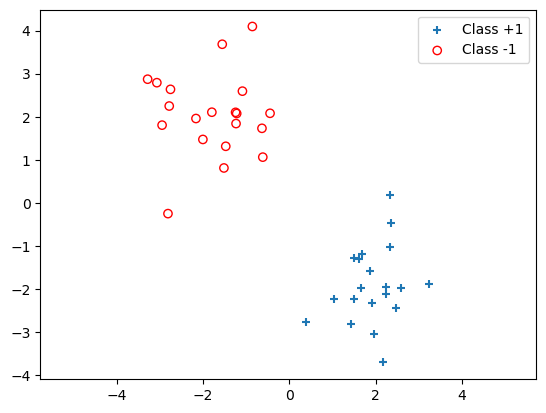

Support vectors: [ 2 25 26]
Count: 3
w = [ 0.5647568  -0.37316087]
b = -0.25534101140017706


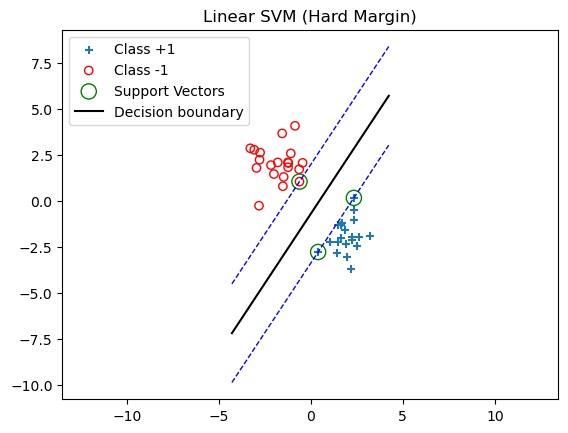

In [ ]:
# Mini Project #5 — Linear SVM 
# James Levi

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Load data
data = loadmat("SVM_data.mat")
x = data["x"]              # (m,2)
d = data["y"].reshape(-1)  # labels +1, -1
m = x.shape[0]

# 2. Plot data
plt.figure()
plt.scatter(x[d==1,0], x[d==1,1], marker='+', label='Class +1')
plt.scatter(x[d==-1,0], x[d==-1,1], facecolors='none', edgecolors='r', marker='o', label='Class -1')
plt.legend(); plt.axis('equal'); plt.show()

# 3. Build Q_ij = dᵢ dⱼ xᵢᵀ xⱼ
G = x @ x.T
Q = np.outer(d, d) * G

# 4. Objective function of dual: (1/2) αᵀ Q α – 1ᵀ α
def objective(alpha):
    return 0.5 * alpha @ Q @ alpha - np.sum(alpha)

# Gradient of objective function (for faster solve)
def objective_grad(alpha):
    return Q @ alpha - np.ones_like(alpha)

# Equality constraint: Σ αᵢ dᵢ = 0
constraints = {
    'type': 'eq',
    'fun': lambda alpha: np.dot(alpha, d)
}

# Bounds: αᵢ ≥ 0
bounds = [(0, None) for _ in range(m)]

# 5. Solve dual problem
alpha0 = np.zeros(m)
result = minimize(objective, alpha0,
                  method='SLSQP',
                  jac=objective_grad,
                  bounds=bounds,
                  constraints=constraints)

alpha = result.x
alpha[alpha < 1e-6] = 0   # numerical cleanup

# 6. Support vectors
SV_idx = np.where(alpha > 0)[0]
print("Support vectors:", SV_idx)
print("Count:", len(SV_idx))

# 7. Compute w = Σ αᵢ dᵢ xᵢ
w = np.sum((alpha * d)[:, None] * x, axis=0)

# 8. Compute bias b using first support vector j
j = SV_idx[0]
b = d[j] - np.dot(w, x[j])

print("w =", w)
print("b =", b)

# 9. Plot decision boundary and margins
xx = np.linspace(min(x[:,0])-1, max(x[:,0])+1, 100)
yy = -(w[0]*xx + b) / w[1]
yy_pos = -(w[0]*xx + b - 1) / w[1]
yy_neg = -(w[0]*xx + b + 1) / w[1]

plt.figure()
plt.scatter(x[d==1,0], x[d==1,1], marker='+', label='Class +1')
plt.scatter(x[d==-1,0], x[d==-1,1], facecolors='none', edgecolors='r', marker='o', label='Class -1')
plt.scatter(x[SV_idx,0], x[SV_idx,1], s=120, edgecolors='g', facecolors='none', label='Support Vectors')

plt.plot(xx, yy, 'k', label='Decision boundary')
plt.plot(xx, yy_pos, 'b--', linewidth=1)
plt.plot(xx, yy_neg, 'b--', linewidth=1)

plt.title("Linear SVM (Hard Margin)")
plt.legend(); plt.axis('equal'); plt.show()


2. Implement a kernel-based support vector machine to separate and classify the two non-
linearly separable sets given in the data file SVM_data_nonlinear.mat available on Canvas.
Find and show the classifying line. How many support vectors do you have? Mark your support
vectors

x shape: (60, 2)
y shape: (60,)


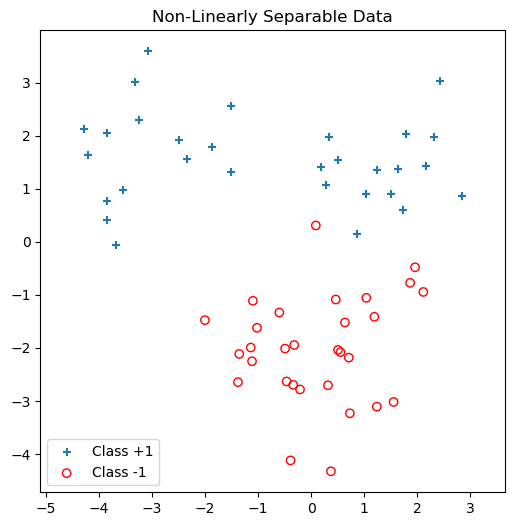

In [10]:

# Part 2: Loading and Plotting the Non-Linearly Separable Data
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Load the data file (same as: load('SVM_data_nonlinear.mat','x','y') in Matlab)
data = loadmat("SVM_data_nonlinear.mat")
x = data["x"]          # size (m, 2)
y = data["y"].ravel()  # labels column → 1D

# same as [m, n] = size(x) in Matlab
m, n = x.shape
print("x shape:", x.shape)
print("y shape:", y.shape)

# Plot the two classes
plt.figure(figsize=(6,6))

# same as plot(x(1:m/2,1),x(1:m/2,2), '+')
plt.scatter(x[:m//2, 0], x[:m//2, 1], marker='+', label="Class +1")

# same as plot(x(m/2+1:m,1), x(m/2+1:m,2), 'rO')
plt.scatter(x[m//2:, 0], x[m//2:, 1], facecolors='none', edgecolors='r', marker='o', label="Class -1")

plt.title("Non-Linearly Separable Data")
plt.legend()
plt.axis('equal')   # same as pbaspect([1 1 1])
plt.show()


Number of support vectors: 6
Bias b = 4.221195441342623


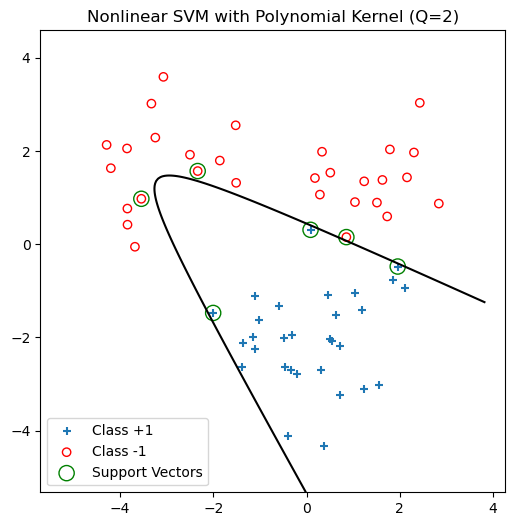

In [ ]:
#   K(x, x') = (1 + x^T x')^Q  (Polynomial Kernel, Q=2 here)
#   Dual:  minimize (1/2 ΣΣ αᵢ αⱼ dᵢ dⱼ K(xᵢ, xⱼ) - Σ αᵢ)
#   subject to:   Σ αᵢ dᵢ = 0,  αᵢ ≥ 0

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Load data
data = loadmat("SVM_data_nonlinear.mat")
x = data["x"]          # (m,2)
d = data["y"].ravel()  # (m,)
m = x.shape[0]

# Define polynomial kernel K(x, x') = (1 + xᵢ·xⱼ)^2 
def polynomial_kernel(x1, x2):
    return (1 + np.dot(x1, x2))**2

# Build Gram matrix using the kernel
K = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        K[i, j] = polynomial_kernel(x[i], x[j])

# Build Q matrix = dᵢ dⱼ K(xᵢ, xⱼ)
Q = np.outer(d, d) * K

# Dual objective:  (1/2 αᵀQα - 1ᵀα)
def objective(alpha):
    return 0.5 * alpha @ Q @ alpha - np.sum(alpha)

def gradient(alpha):
    return Q @ alpha - np.ones(m)

# Constraint: Σ αᵢ dᵢ = 0
constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, d)}

# Bounds: αᵢ ≥ 0
bounds = [(0, None)] * m

# 4. Solve for α
alpha0 = np.zeros(m)
solution = minimize(objective, alpha0, jac=gradient, bounds=bounds, constraints=constraints)
alpha = solution.x
alpha[alpha < 1e-6] = 0

# Support vectors
SV_idx = np.where(alpha > 0)[0]
print("Number of support vectors:", len(SV_idx))

# Compute bias 'b' using any support vector j (from notes)
# b = dⱼ - Σ αᵢ dᵢ K(xᵢ, xⱼ)
j = SV_idx[0]
b = d[j] - np.sum(alpha * d * K[:, j])

print("Bias b =", b)

# Decision function using kernel:
# f(z) = Σ αᵢ dᵢ K(xᵢ, z) + b
def f(z):
    total = 0
    for i in range(m):
        if alpha[i] > 0:
            total += alpha[i] * d[i] * polynomial_kernel(x[i], z)
    return total + b

# Plot decision boundary
plt.figure(figsize=(6,6))
plt.scatter(x[d==1,0], x[d==1,1], marker='+', label='Class +1')
plt.scatter(x[d==-1,0], x[d==-1,1], facecolors='none', edgecolors='r', marker='o', label='Class -1')

# Highlight support vectors
plt.scatter(x[SV_idx,0], x[SV_idx,1], s=120, facecolors='none', edgecolors='g', label='Support Vectors')

# Create grid for decision boundary
xx, yy = np.meshgrid(np.linspace(min(x[:,0])-1, max(x[:,0])+1, 200),np.linspace(min(x[:,1])-1, max(x[:,1])+1, 200))

zz = np.zeros_like(xx)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i,j] = f(np.array([xx[i,j], yy[i,j]]))

plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=1.5, linestyles='-')  # decision boundary
plt.title("Nonlinear SVM with Polynomial Kernel (Q=2)")
plt.legend()
plt.axis('equal')
plt.show()
